# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import copy
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
def make_dummy_from_list(df, col_name):
    """
    input : df with colulmn with list of values
    
    output: df with one hot encoding approach
    """

    dummy_df = pd.get_dummies(df[col_name].apply(pd.Series).stack(), prefix= col_name).sum(level=0)
    
    final_df = pd.concat([df, dummy_df], axis=1, sort=False)
    final_df.drop(columns=col_name, inplace=True)
    return final_df

In [3]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


# 1. Data Clean up

## 1.a portfolio - offers Data Set

In [4]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


We need to:
* create dummy variables for channels
* rename columns id that is reffering to offer
* change duration from days to hours

In [5]:
portfolio1 = make_dummy_from_list(portfolio, 'channels')
portfolio1 = portfolio1.rename(columns = {'id' : 'offer_id'})
portfolio1.duration = portfolio1.duration * 24
print(len(portfolio1))
portfolio1.head(20)

10


,reward,difficulty,duration,offer_type,offer_id,channels_email,channels_mobile,channels_social,channels_web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


As we can see portfolio data set have 10 records and we don't have any other issues.

## 1.b profile - users Data Set

In [6]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [8]:
missing_age_rows = len(profile[profile['age'].isna()]) / len(profile)
missing_became_member_on_rows = len(profile[profile['became_member_on'].isna()]) / len(profile)
missing_gender_rows = len(profile[profile['gender'].isna()]) / len(profile)
missing_id_rows = len(profile[profile['id'].isna()]) / len(profile)
missing_income_rows = len(profile[profile['income'].isna()]) / len(profile)

print('missing rows:')
print(f'age = {missing_age_rows}')
print(f'became_member_on = {missing_became_member_on_rows}')
print(f'gender = {missing_gender_rows}')
print(f'id = {missing_id_rows}')
print(f'income = {missing_income_rows}')

missing rows:
age = 0.0
became_member_on = 0.0
gender = 0.12794117647058822
id = 0.0
income = 0.12794117647058822


### Age column investigation
We can see that mean values for **age** in our data set is a little too high - **62 years**.

<AxesSubplot:>

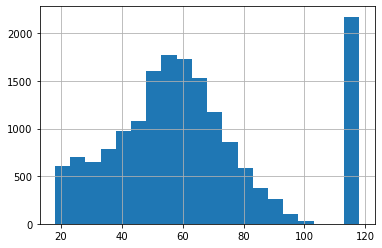

In [9]:
profile['age'].hist(bins = 20)

In [10]:
len(profile[(profile['age'] == 118) & (profile['gender'].isna())]) / len(profile[profile['age'] == 118])

1.0

In [11]:
len(profile[(profile['age'] == 118) & (profile['income'].isna())]) / len(profile[profile['age'] == 118])

1.0

### Age column solution
Since **100%** of rows with **age = 118** have missing values on **gender** and **income** columns we should drop those rows.
After that we don't have any missing values.

In [12]:
profile1 = profile[profile['age'] != 118]
profile1[profile1.isna().any(axis=1)].size

0

### Data preparation for further analysis
We need to:
* rename column id that is reffering to users
* change became_member_on format to date time format

In [13]:
profile1['became_member_on'] = pd.to_datetime(profile1['became_member_on'], format='%Y%m%d')
profile1['became_member_on_year'] = profile1['became_member_on'].apply(lambda x: x.year)
profile1['became_member_on_month'] = profile1['became_member_on'].apply(lambda x: x.month)

profile1 = profile1.drop(columns = ['became_member_on'])

profile1 = profile1.rename(columns = {'id' : 'user_id'})
profile1.head()

<ipython-input-13-3858de13c373>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile1['became_member_on'] = pd.to_datetime(profile1['became_member_on'], format='%Y%m%d')
<ipython-input-13-3858de13c373>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile1['became_member_on_year'] = profile1['became_member_on'].apply(lambda x: x.year)
<ipython-input-13-3858de13c373>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,gender,age,user_id,income,became_member_on_year,became_member_on_month
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11


## 1.c transcript - actions Data Set

In [14]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [15]:
transcript.count()

person    306534
event     306534
value     306534
time      306534
dtype: int64

In [16]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [17]:
transcript.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714], dtype=int64)

In [18]:
transcript.time.max()/24

29.75

### Data preprocessing
We have to split values from **value** column into seperate columns

In [19]:
transcript1 = copy.deepcopy(transcript)

transcript1['amount'] = transcript1.value.apply(lambda x: x['amount']*1.00 if 'amount' in x else None)
transcript1['reward'] = transcript1.value.apply(lambda x: x['reward']*1.00 if 'reward' in x else None)
transcript1['offer_id'] = transcript1.value.apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))

transcript1 = transcript1.drop(columns = ['value'])
transcript1 = transcript1.rename(columns = {'person' : 'user_id'})

transcript1.groupby(['event']).count()

,user_id,time,amount,reward,offer_id
event,,,,,
offer completed,33579,33579,0,33579,33579
offer received,76277,76277,0,0,76277
offer viewed,57725,57725,0,0,57725
transaction,138953,138953,138953,0,0


In [20]:
transcript1.groupby(['event']).count()

,user_id,time,amount,reward,offer_id
event,,,,,
offer completed,33579,33579,0,33579,33579
offer received,76277,76277,0,0,76277
offer viewed,57725,57725,0,0,57725
transaction,138953,138953,138953,0,0


In [21]:
len(transcript1[transcript1['event'] != 'transaction'])

167581

In [22]:
len(transcript1[transcript1['event'] == 'transaction'])

138953

As we can see transaction event are not corelated with offer id.
We can split transcript dataset into two sub data sets:
* transcript_offer
* transcript_transaction

In [23]:
transcript_offer = transcript1[transcript1['event'] != 'transaction']
transcript_transaction = transcript1[transcript1['event'] == 'transaction']

In [24]:
# We drop unnecessery columns
transcript_offer = transcript_offer.drop(columns = ['amount'])
transcript_transaction = transcript_transaction.drop(columns = ['reward', 'offer_id'])

In [25]:
# Rename values
transcript_offer['event'] = transcript_offer['event'].apply(lambda x: '3: offer completed' if x == 'offer completed' else 
                                                           ('1: offer received' if x == 'offer received' else '2: offer viewed'))

# THIS PART TAKES 1.5 hour to run !

In [26]:
# THIS PART TAKES 1.5 hour !!!!!!!!!!!!!!!!!!!!


# from tqdm.notebook import trange, tqdm

# transcript_offer = transcript_offer.merge(portfolio1, how = 'left', on = 'offer_id')
# transcript_offer = transcript_offer.rename(columns = {'reward_x' : 'reward_completed', 'reward_y' : 'reward_possible'})

# curr_sent_id = 0
# offer_id_list = []


# transcript_offer = transcript_offer.sort_values(by = ['user_id', 'offer_id', 'time'])

# transcript_offer['sent_id'] = None
# df_w = copy.deepcopy(transcript_offer)

# for index, row in tqdm(transcript_offer.iterrows(), total=transcript_offer.shape[0]):
#     if row['event'] == '1: offer received':
#         curr_df = copy.deepcopy(transcript_offer[
#                                     (transcript_offer['user_id'] == row['user_id']) & 
#                                      (transcript_offer['offer_id'] == row['offer_id']) & 
#                                      (transcript_offer['time'] >= row['time']) &
#                                      (transcript_offer['time'] <= (row['time'] + row['duration'])) &
#                                      (transcript_offer['sent_id'].isna())
#                                       ])

#         curr_df_viewed = curr_df[curr_df['event'] == '1: offer received']
#         min_time = curr_df_viewed.time.min()
#         curr_df_viewed = curr_df_viewed[curr_df_viewed.time == min_time]
#         min_index = curr_df_viewed.index.min()
#         curr_df_viewed = curr_df_viewed[curr_df_viewed.index == min_index]
#         transcript_offer.loc[min_index, 'sent_id'] = curr_sent_id
        
#         curr_df_viewed = curr_df[curr_df['event'] == '2: offer viewed']
#         min_time = curr_df_viewed.time.min()
#         curr_df_viewed = curr_df_viewed[curr_df_viewed.time == min_time]
#         min_index = curr_df_viewed.index.min()
#         curr_df_viewed = curr_df_viewed[curr_df_viewed.index == min_index]
#         transcript_offer.loc[min_index, 'sent_id'] = curr_sent_id
        
#         curr_df_viewed = curr_df[curr_df['event'] == '3: offer completed']
#         min_time = curr_df_viewed.time.min()
#         curr_df_viewed = curr_df_viewed[curr_df_viewed.time == min_time]
#         min_index = curr_df_viewed.index.min()
#         curr_df_viewed = curr_df_viewed[curr_df_viewed.index == min_index]
#         transcript_offer.loc[min_index, 'sent_id'] = curr_sent_id
        
#         curr_sent_id += 1
        
# transcript_offer.to_csv('transcript_offer.csv')
# transcript_offer.head()

In [27]:
transcript_offer = pd.read_csv('transcript_offer.csv')

In [28]:
fixed_send_id_list = []
cur_x = None
for x in list(transcript_offer['sent_id']):
    if x != None:
        cur_x = x
    fixed_send_id_list.append(cur_x)

transcript_offer['sent_id'] = fixed_send_id_list

In [108]:
transcript_offer_pivot = pd.pivot_table(transcript_offer, values=['time', 'reward_completed'], index=['user_id', 'offer_id', 'sent_id'], columns=['event'], aggfunc= 'sum')
transcript_offer_pivot.columns = transcript_offer_pivot.columns.droplevel()
transcript_offer_pivot = transcript_offer_pivot.reset_index(col_level=1)
transcript_offer_pivot = transcript_offer_pivot.reset_index(drop = True)
transcript_offer_pivot.columns = ['user_id', 'offer_id', 'sent_id' , '1: received reward',
                                  '2: viewed reward','3: completed reward', '1: received time',
                                  '2: viewed time','3: completed time']
transcript_offer_pivot.head(10)

,user_id,offer_id,sent_id,1: received reward,2: viewed reward,3: completed reward,1: received time,2: viewed time,3: completed time
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,NaN,2.0,576.0,NaN,576.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,0.0,0.0,NaN,336.0,372.0,NaN
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,2.0,0.0,0.0,NaN,168.0,192.0,NaN
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,3.0,0.0,0.0,5.0,408.0,456.0,414.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4.0,0.0,0.0,2.0,504.0,540.0,528.0
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0.0,0.0,NaN,168.0,216.0,NaN
6,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,6.0,0.0,0.0,NaN,576.0,630.0,NaN
7,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,7.0,0.0,0.0,5.0,408.0,432.0,576.0
8,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,8.0,0.0,0.0,3.0,168.0,186.0,252.0
9,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,9.0,0.0,0.0,NaN,0.0,6.0,NaN


# Merge Data Sets

In [30]:
df = transcript_offer_pivot.merge(portfolio1, how = 'inner', on = 'offer_id')
df = df.drop(columns = ['1: received reward', '2: viewed reward'])
df = df.rename(columns = {'3: completed reward' : 'reward_completed'})
df = df.merge(profile1, how = 'inner', on = 'user_id')

print(len(df))
df.head()

66501


,user_id,offer_id,sent_id,reward_completed,1: received time,2: viewed time,3: completed time,reward,difficulty,duration,offer_type,channels_email,channels_mobile,channels_social,channels_web,gender,age,income,became_member_on_year,became_member_on_month
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,2.0,576.0,NaN,576.0,2,10,168,discount,1,1,0,1,M,33,72000.0,2017,4
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,NaN,336.0,372.0,NaN,0,0,96,informational,1,1,0,1,M,33,72000.0,2017,4
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,2.0,NaN,168.0,192.0,NaN,0,0,72,informational,1,1,1,0,M,33,72000.0,2017,4
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,3.0,5.0,408.0,456.0,414.0,5,5,120,bogo,1,1,1,1,M,33,72000.0,2017,4
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,4.0,2.0,504.0,540.0,528.0,2,10,240,discount,1,1,1,1,M,33,72000.0,2017,4


In [48]:
df_transactions = copy.deepcopy(transcript_transaction)
df_transactions = df_transactions.groupby(['user_id'], as_index = False).sum()
df_transactions = df_transactions.merge(profile1, how = 'inner', on = 'user_id')
df_transactions.head()

,user_id,time,amount,gender,age,income,became_member_on_year,became_member_on_month
0,0009655768c64bdeb2e877511632db8f,4344,127.60,M,33,72000.0,2017,4
1,0011e0d4e6b944f998e987f904e8c1e5,2256,79.46,O,40,57000.0,2018,1
2,0020c2b971eb4e9188eac86d93036a77,2790,196.86,F,59,90000.0,2016,3
3,0020ccbbb6d84e358d3414a3ff76cffd,4500,154.05,F,24,60000.0,2016,11
4,003d66b6608740288d6cc97a6903f4f0,7590,48.34,F,26,73000.0,2017,6


# 2. Explorary Analysis

## 2.1 - Gender distribution of customers

In [229]:
fig = px.histogram(profile1, x="gender", color = 'gender')
fig.show()

## 2.2 - Averange spending per gender

In [227]:
df_c = copy.deepcopy(df_transactions)
df_c = df_c.groupby(['gender'], as_index = False).agg({'amount' : 'mean'})
df_c = df_c.rename(columns = {'amount' : 'averange spending'})

fig = px.bar(df_c, x="gender",y = 'averange spending', color = 'gender')
fig.show()

## 2.3 - Age and spending distribution of customers

In [203]:
df_c = copy.deepcopy(df_transactions)
df_c['age'] = df_c['age'].apply(lambda x: round(x/5)*5)
df_c = df_c.groupby(['age'], as_index = False).agg({'amount' : 'mean', 'user_id': 'nunique'})
df_c = df_c.rename(columns = {'amount' : 'averange spending'})
df_c.head(10)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_c["age"], y= df_c['averange spending'], name="averange spending"
              ,marker_color= 'steelblue'),
    secondary_y=True, 
)


fig.add_trace(
    go.Bar(x=df_c["age"], y=df_c['user_id'], name="number of customer" ,marker_color= 'skyblue'),
    secondary_y=False
)

fig.update_layout(title_text="<b> Age and spending distribution of customers")

# Set x-axis title
fig.update_xaxes(title_text="<b>Age<b>")

# Set y-axes titles
fig.update_yaxes(title_text="Number of customer", secondary_y=False)
fig.update_yaxes(title_text="Averange spending", secondary_y=True)

fig.show()

## 2.4 - Income and spending distribution of customers

In [198]:
df_c = copy.deepcopy(df_transactions)
df_c['income'] = df_c['income'].apply(lambda x: round(x/5000)*5000)
df_c = df_c.groupby(['income'], as_index = False).agg({'amount' : 'mean', 'user_id': 'nunique'})
df_c = df_c.rename(columns = {'amount' : 'averange spending'})
df_c.head(10)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df_c["income"], y= df_c['averange spending'], name="averange spending"
              ,marker_color= 'black'),
    secondary_y=True, 
)


fig.add_trace(
    go.Bar(x=df_c["income"], y=df_c['user_id'], name="number of customer", marker_color= 'gray'),
    secondary_y=False
)

fig.update_layout(title_text="<b> Income and spending distribution of customers")

# Set x-axis title
fig.update_xaxes(title_text="<b>Income<b>")

# Set y-axes titles
fig.update_yaxes(title_text="Number of customer", secondary_y=False)
fig.update_yaxes(title_text="Averange spending", secondary_y=True)

fig.show()

## 2.5 - Year of becomimng member distribution of customers by gender

In [107]:
fig = px.histogram(profile1, x="became_member_on_year",barmode='group', color='gender' )
fig.show()

In [ ]:
## 2.4 

# Prediciton Model

In [34]:
df1 = copy.deepcopy(df)
df1['end_status'] = df1['3: completed time'].apply(lambda x: 0 if pd.isna(x) else 1)
df1 = df1.drop(columns = ['user_id', 'offer_id', 'sent_id', 'reward_completed', '1: received time',
                          '2: viewed time', '3: completed time'])

df1['income'] = df1['income'].apply(lambda x: round(x/20000)*20000 )


# get dummies for gender column
df_cat = pd.get_dummies(df1['gender'], dummy_na = False, drop_first=False)
df1 = df1.merge(df_cat, how = 'inner', left_index = True, right_index= True)

df_cat = pd.get_dummies(df1['offer_type'], dummy_na = False, drop_first=False)
df1 = df1.merge(df_cat, how = 'inner', left_index = True, right_index= True)

df1 = df1.drop(columns = ['gender', 'offer_type'])

df1.head()

,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,age,income,became_member_on_year,became_member_on_month,end_status,F,M,O,bogo,discount,informational
0,2,10,168,1,1,0,1,33,80000,2017,4,1,0,1,0,0,1,0
1,0,0,96,1,1,0,1,33,80000,2017,4,0,0,1,0,0,0,1
2,0,0,72,1,1,1,0,33,80000,2017,4,0,0,1,0,0,0,1
3,5,5,120,1,1,1,1,33,80000,2017,4,1,0,1,0,1,0,0
4,2,10,240,1,1,1,1,33,80000,2017,4,1,0,1,0,0,1,0


In [35]:
from sklearn.naive_bayes import GaussianNB 
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
import plotly.express as px
import datetime
from collections import defaultdict
from tqdm import tqdm
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
# from imblearn.over_sampling import SMOTE

In [36]:
def train_predict_result(model, X_train, y_train, X_test, y_test):
    results = {}
    
    #fit the model
    model.fit(X_train, y_train)
    
    #predict test
    y_pred_test = model.predict(X_test)
    
    #predict train
    y_pred_train = model.predict(X_train)
    
    #Accuracy of training
    results['acc_train'] = accuracy_score(y_train, y_pred_train)
    
    #Accuracy of testing
    results['acc_test'] = accuracy_score(y_test, y_pred_test)
    
    #f1-score for training
    results['f1_train'] = f1_score(y_train, y_pred_train)
    
    #f1-score for testing
    results['f1_test'] = f1_score(y_test, y_pred_test)
    
    print("{} trained.".format(model.__class__.__name__))
        
    # Return the results
    return results

In [37]:
# Initialize the models

logreg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=600,
                            random_state=10)
randomforestclf = RandomForestClassifier(random_state=10)
gnb = GaussianNB()
knn = KNeighborsClassifier() 
dectree = DecisionTreeClassifier()
xgb = XGBClassifier(use_label_encoder=False,
                   objective = 'binary:logistic',
                   eval_metric = 'error')

models = [logreg, randomforestclf, gnb, knn, dectree, xgb]

In [38]:
df1.dtypes

reward                    int64
difficulty                int64
duration                  int64
channels_email            uint8
channels_mobile           uint8
channels_social           uint8
channels_web              uint8
age                       int64
income                    int64
became_member_on_year     int64
became_member_on_month    int64
end_status                int64
F                         uint8
M                         uint8
O                         uint8
bogo                      uint8
discount                  uint8
informational             uint8
dtype: object

In [39]:
df1.head()

,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,age,income,became_member_on_year,became_member_on_month,end_status,F,M,O,bogo,discount,informational
0,2,10,168,1,1,0,1,33,80000,2017,4,1,0,1,0,0,1,0
1,0,0,96,1,1,0,1,33,80000,2017,4,0,0,1,0,0,0,1
2,0,0,72,1,1,1,0,33,80000,2017,4,0,0,1,0,0,0,1
3,5,5,120,1,1,1,1,33,80000,2017,4,1,0,1,0,1,0,0
4,2,10,240,1,1,1,1,33,80000,2017,4,1,0,1,0,0,1,0


In [40]:

Y = df1['end_status']
X = df1.drop(columns = ['end_status'])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/3, random_state=0)

In [41]:
result_dict = {}
for model in models:
    model_name = model.__class__.__name__
    result_dict[model_name] = train_predict_result(model, X_train, y_train, X_test, y_test)

LogisticRegression trained.
RandomForestClassifier trained.
GaussianNB trained.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\SzymonGrzebyta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-16cb41e8489b>", line 4, in <module>
    result_dict[model_name] = train_predict_result(model, X_train, y_train, X_test, y_test)
  File "<ipython-input-36-371b2b44df18>", line 11, in train_predict_result
    y_pred_train = model.predict(X_train)
  File "C:\Users\SzymonGrzebyta\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 197, in predict
    neigh_dist, neigh_ind = self.kneighbors(X)
  File "C:\Users\SzymonGrzebyta\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 705, in kneighbors
    chunked_results = list(pairwise_distances_chunked(
  File "C:\Users\SzymonGrzebyta\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py", line 1623, in pairwise_distances_chunked
    D_chunk = pairwise_distances(X_chunk, Y, metric=metr

TypeError: object of type 'NoneType' has no len()

In [ ]:
for mod in range(len(models)):
    print(models[mod].__class__.__name__, ":")
    display(pd.DataFrame(result_dict[models[mod].__class__.__name__], index = range(1)))
    print('===================================\n\n')

In [ ]:
# create a dictionary of parameters to test
xgb_grid_params = {'objective': ['binary:logistic'],
                   'eval_metric': ['error'],
                   'use_label_encoder':[False],
                 'gamma': [0, 0.5],
                 'learning_rate': [0.300000012, 0.25, 0.35],
                 'max_depth': [6, 5, 7]}

In [ ]:
# configure the cross-validation procedure
cv = KFold(n_splits=6, shuffle=True, random_state=1)

xgb_grid = GridSearchCV(estimator=xgb,
                    param_grid=xgb_grid_params,
                    scoring='accuracy',
                    cv = cv,
                    verbose=10)
xgb_grid.fit(X_train, y_train)

In [ ]:
#show the best parameters based on grid search
best_params = xgb_grid.best_params_
best_params

In [ ]:
xgb_acc = {}
# instantiate and train model with best parameters
xgb_best = XGBClassifier(eval_metric= 'error',
                         gamma=0.5,
                        learning_rate = 0.300000012,
                        max_depth = 6,
                        objective = 'binary:logistic',
                        use_label_encoder = False)
xgb_acc['XGBoost Classifier'] = train_predict_result(xgb_best,X_train, y_train, X_test, y_test)

In [ ]:
print(xgb_best.__class__.__name__, ":")
display(pd.DataFrame(xgb_acc['XGBoost Classifier'], index = range(1)))

In [ ]:

import plotly.express as px
import datetime
from collections import defaultdict
from tqdm import tqdm
pd.options.mode.chained_assignment = None
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import learning_curve

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(3, 1, figsize=(10, 30))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
plot_learning_curve(xgb_best, 'title', X, Y, ylim=(0.5, 1.01),
                    cv=cv, n_jobs=4);